(you can download this post as a notebook [here](https://github.com/mglerner/mglerner.github.io/blob/master/posts/visualizing-differential-geometry-in-jupyter-notebooks.ipynb))

# Visualizing differential geometry in Jupyter notebooks

I taught a senior seminar on differential geometry last year. I'll be honest: it was a selfish course. [Markus Deserno](https://www.cmu.edu/physics/people/faculty/deserno.html) writes all of these cool papers about membranes, and I didn't know enough math to follow them. So, the goal of our course was basically to learn enough differential geometry to read several of his papers. It was fantastic. We used several of his papers, as well as Kreyszig's textbook, as our core materials. 

Here's the thing: a lot of this was pretty foreign to my physics students. In particular, the discussion of surfaces and mappings was new. So, we wrote some tools in Jupyter Notebooks to help us visualize and solve problems. I particularly like the stuff we wrote to visualize a mapping, and I don't know of a comparable resource elsewhere. Let's jump in.

### The punchline: how do you map a surface to a curve?

As a teaser, here's how $(u_1,u_2) \to (u_1+u_2, (u_1+u_2)^2, (u_1+u_2)^3)$ maps a surface to a curve. As you play the animation, the green surface slowly interpolates from the $(u_1, u_2)$ patch to the curve, following the red arrows. Watching this work for several different mappings cleared a lot up for my class.

OK. Cool. Now let's talk differential geometry for a bit.

# Surfaces

We get our introduction to surfaces in Kreyszig Ch. 3. Specifically, $\S3.24$ In most of our classes, we've defined surfaces like

$$z = f(x,y) $$

and we've been good at visualizing them. Here, we run into the definition of a surface in terms of a mapping that sends

$$ (u_1,u_2) \to (x(u_1,u_2), y(u_1,u_2), z(u_1,u_2)) $$

and Kreyszig warns us that something like

$$ (u_1+u_2, (u_1+u_2)^2, (u_1+u_2)^3) $$

is problematic because, since it can be parameterized by a single variable, it's actually a curve rather than a surface. We also run into the Jacobian and some linear algebra. Our goal right now is to work with concrete curves and surfaces in $\mathbb{R}^3$ So, let's figure out how to visualize these sorts of mappings. First, some gunk to set up our python environment. For the experts, note that we could use `%matplotlib notebook` to make things prettier, but it seems really slow.

In [1]:
import numpy as np, scipy as sp, pandas as pd, seaborn as sns, matplotlib.pyplot as plt, matplotlib as mpl
import itertools
from mpl_toolkits.mplot3d import Axes3D, proj3d
import matplotlib.animation as animation
from matplotlib.patches import FancyArrowPatch
from IPython.display import HTML
from ipywidgets import interact, interactive, fixed

In class, we used `interact` to visualize things. However, I'm making this available on the web using the fact that Jake Vanderplas' awesome JSAnimation package is built in to matplotlib 2.1. I still strongly recommend `interact` for playing around on your own server.

In [ ]:
# mpl.rcParams['animation.html'] = 'jshtml'
# Doesn't seem to work for me, so I make the HTML explicitly below

Now, let's just try one of these out. One of the examples we want to look at in the book is 

$$ (u_1+u_2, \sin(u_1), \cos(u_1+u_2)) $$

so let's make a grid of points where $u_1$ and $u_2$ vary from -2 to 2, then plot the corresponding surface. We'll plot $(u_1, u_2, 0)$ in grey and the surface in blue.

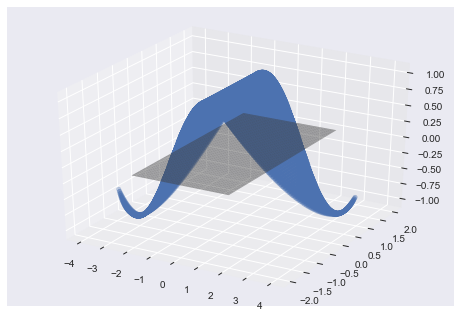

In [2]:
u1 = np.linspace(-2,2,100)
u2 = np.linspace(-2,2,100)
U1, U2 = np.meshgrid(u1, u2)
X = U1 + U2
Y = np.sin(U1)
Z = np.cos(U1+U2)

ax = plt.gca(projection='3d')
surf2 = ax.plot_surface(U1, U2, np.zeros_like(U1), color='grey', alpha=0.5)
surf = ax.scatter(X, Y, Z)
plt.show()

You can play around with the above, using more or fewer points, etc. You can clearly see that the surface extends vertically and horizontally beyond the patch from $u_1$ and $u_2$, although it's kind of cheating to plot them both at the same time. So let's wrap that up in a function and try it with different maps.

To make it cuter, we'll draw red arrows from some specific points to see which points get mapped where. And we'll plot a surface not a collection of points, by default, because it's way faster. Most impoartantly, we'll wrap all of the plotting stuff up in a function of its own so that we just need to define a map, and then ask to plot it.

In [3]:
class Arrow3D(FancyArrowPatch):
    #http://stackoverflow.com/questions/22867620/putting-arrowheads-on-vectors-in-matplotlibs-3d-plot
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

We played around with things quite a bit in class, so the function below has options for changing from `surface` to `points` ... in this notebook, I just stick with the surface, but you should play interactively!

In [4]:
def plot_surface(f,plotmode='surface',urange=2*np.pi):
    u1 = np.linspace(-urange,urange,100)
    u2 = np.linspace(-urange,urange,100)
    ax = plt.gca(projection='3d')
    U1, U2 = np.meshgrid(u1, u2)
    X,Y,Z = f(U1,U2)
    surf2 = ax.plot_surface(U1, U2, np.zeros_like(U1), color='grey', alpha=0.5)
    if plotmode == 'surface':
        surf = ax.plot_surface(X,Y,Z)
    elif plotmode == 'points':
        surf = ax.scatter(X,Y,Z)
    else:
        raise Exception('Unknown plot mode {p}'.format(p=plotmode))
    for (w1,w2) in itertools.permutations([-urange,-urange/2,0,urange/2,urange],2):
        x,y,z = f(w1,w2)
        a = Arrow3D([w1,x],[w2,y],[0,z], mutation_scale=20, 
                    lw=1, arrowstyle="-|>", color="r",
                   alpha=0.7,zorder=-1)
        ax.add_artist(a)
    plt.show()

And now let's plot that same surface $(u_1,u_2) \to u_1 + u_2, \sin(u_1), \cos(u_1+u_2)$

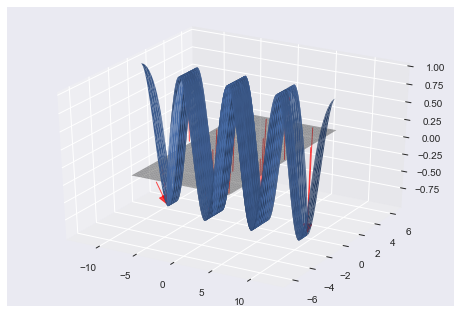

In [5]:
def f(X,Y):
    return X+Y, np.sin(X), np.cos(X+Y)
plot_surface(f)

## Changing the $(u1,u2)$ patch

We spent a bit of time thinking about what exactly $u1$ and $u2$ were doing. If you make their range bigger or smaller, you change the size of the surface. That's built into the function defined above. By default, they each go from `-urange` to `urange`. As you can see in the figure above, `urange` defaults to $2\pi$. We can look at a smaller patch to see what's going on:

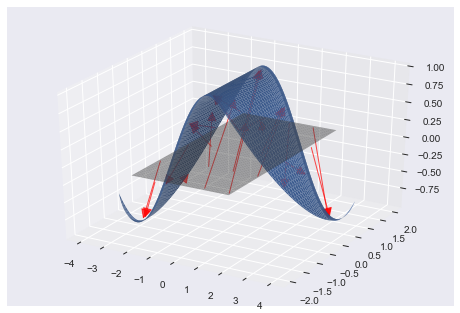

In [6]:
plot_surface(f,urange=2)

## Playing around

At this point, the class just played around with the results. Everybody defined their own functions, and looked at the resulting maps. You can do that too if you run the notebook interactively! Here's one that the students particularly liked, despite the attempted bad math.

/Users/mglerner/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/Users/mglerner/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/Users/mglerner/anaconda3/lib/python3.6/site-packages/mpl_toolkits/mplot3d/proj3d.py:141: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


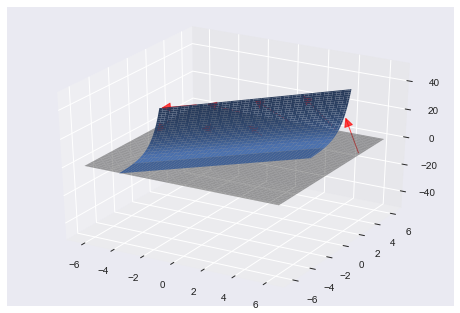

In [7]:
def f(X,Y):
    return X,np.log(Y),3*X+5*Y
plot_surface(f)

# The curve

OK. A large portion of why we did this was because it was really not obvious to the class why $(u_1+u_2, (u_1+u_2)^2, (u_1+u_2)^3)$ mapped to a curve. We could all follow the mathematical arguments, but it didn't really stick without a good visualization. So, let's look:

so, what does the curve look like?

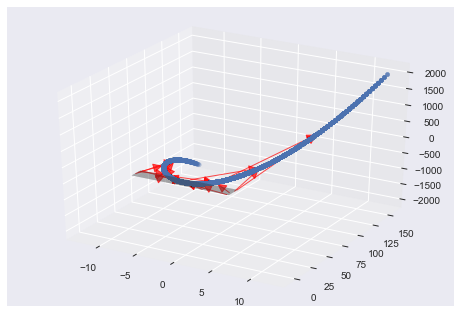

In [8]:
def f(X,Y):
    return X+Y, (X+Y)**2, (X+Y)**3
plot_surface(f, plotmode='points')

That's a great start. We can see where representative points match, and it's definitely useful to visualize things and "prove" to ourselves that you do indeed get a curve. It's much more convincing when we make an interactive version (below). Before we do that, let's also quickly check out a cylinder.

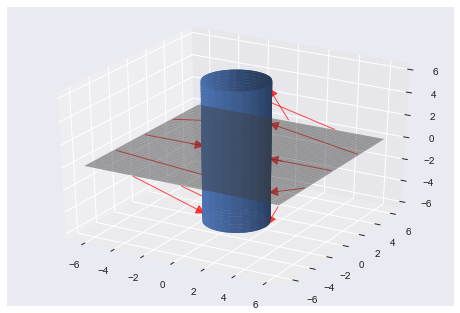

In [9]:
def f(X,Y):
    return 2*np.cos(X),2*np.sin(X),Y
plot_surface(f)

In class, we played around with `urange` and the scale factors to make sure we understood what was going on.

# An interactive one

That was OK, and it convinced us that the maps really did go from, e.g., a plane to a cylinder. But it still wasn't quite so obvious exactly how/why it worked. 

Then I had the idea to make it interactive: you get a slider so you can watch the green surface interpolate linearly between the grey patch $(u_1,u_2)$ and the surface defined by $(x,y,z)$. This is worth running interactively, and playing with, as it really cleared things up. If you run it locally and interactively, you get sliders that let you rotate the surface around in 3D, so you can look at it from all angles. If you're runnign it locally, you wnat the interp step to be more like 0.01 and the degree step to be more like 1. For notebooks to be viewable online, I'm using a coarser step on interp, and I'm skipping the degree steps altogether.

In [10]:
def plot_surface_interpolate(f=f,plotmode='surface',urange=2*np.pi,interp=0.1,elev=None,azim=None):
    u1 = np.linspace(-urange,urange,100)
    u2 = np.linspace(-urange,urange,100)
    #fig = plt.figure()
    ax = plt.gca(projection='3d')
    U1, U2 = np.meshgrid(u1, u2)
    X,Y,Z = f(U1,U2)
    U3 = np.zeros_like(Z)
    A = (1-interp)*U1 + interp*X
    B = (1-interp)*U2 + interp*Y
    C = (1-interp)*U3 + interp*Z
    surf2 = ax.plot_surface(U1, U2, np.zeros_like(U1), color='grey', alpha=0.5)
    if plotmode == 'surface':
        surf = ax.plot_surface(X,Y,Z,alpha=0.9,color='blue')
        surf3 = ax.plot_surface(A,B,C,color='green',zorder=-2,alpha=0.9)
    elif plotmode == 'points':
        surf = ax.scatter(X,Y,Z,alpha=0.9,color='blue')
        surf3 = ax.scatter(A,B,C,color='green',zorder=-2,alpha=0.9)
    else:
        raise Exception('Unknown plot mode {p}'.format(p=plotmode))
    
    for (w1,w2) in itertools.permutations([-urange,-urange/2,0,urange/2,urange],2):
        x,y,z = f(w1,w2)
        a = Arrow3D([w1,x],[w2,y],[0,z], mutation_scale=20, 
                    lw=1, arrowstyle="-|>", color="r",
                   alpha=0.7,zorder=-1)
        ax.add_artist(a)
    ax.view_init(elev=elev,azim=azim)
    plt.show()

In [11]:
# You can change this to %matplotlib notebook if you want. It looks better, but is much slower for me.
#%matplotlib inline

## Now play with the `interp` slider, to see how you'd interpolate linearly from $(u_1, u_2)$ to $(x,y,z)$

We just looked at mapping the plane to a cylinder, so we'll start with it. I made my students describe what they thought would happen first, which was a good idea, because the real mapping is actually a bit subtle.

In [12]:
interp_step = 0.01
degree_step=1

In [13]:
def plot_this(interp=0.1,azim=30,elev=30,plotmode='surface'):
    def f(X,Y):
        return 2*np.cos(X),2*np.sin(X),Y
    plot_surface_interpolate(f,interp=interp,azim=azim,elev=elev,plotmode=plotmode)
interact(plot_this,interp=(0,1,interp_step),
         azim=(0,360,degree_step),
         elev=(0,360,degree_step),
         plotmode=['points','surface']);

Or, if you're looking at the blog post and want an animation where the slider controls the interpolation ...

First, the boilerplate code

In [14]:
def update_interp(i,f,surfs,elev=30,azim=30,urange=2*np.pi):

    surf,surf2,surf3 = surfs
    ax.clear()
    interp = i/10
    A = (1-interp)*U1 + interp*X
    B = (1-interp)*U2 + interp*Y
    C = (1-interp)*U3 + interp*Z

    surf2 = ax.plot_surface(U1, U2, np.zeros_like(U1), color='grey', alpha=0.5)
    surf = ax.plot_surface(X,Y,Z,alpha=0.5,color='blue')
    surf3 = ax.plot_surface(A,B,C,color='green',zorder=-2,alpha=0.9)

    for (w1,w2) in itertools.permutations([-urange,-urange/2,0,urange/2,urange],2):
        x,y,z = f(w1,w2)
        a = Arrow3D([w1,x],[w2,y],[0,z], mutation_scale=20, 
                    lw=1, arrowstyle="-|>", color="r",
                   alpha=0.7,zorder=-1)
        ax.add_artist(a)
    ax.view_init(elev=elev,azim=azim)
    return (surf,surf2,surf3)
urange=2*np.pi
u1 = np.linspace(-urange,urange,100)
u2 = np.linspace(-urange,urange,100)
U1, U2 = np.meshgrid(u1, u2)
U3 = np.zeros_like(U1)

Then the code for the cylinder mapping. **Play with the slider to change the interploation! Step through frame-by-frame, or play the animation. Use the +/- controls to speed up/slow down the animation!**

In [15]:
def f(X,Y):
    return 2*np.cos(X),2*np.sin(X),Y

X,Y,Z = f(U1,U2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


surf2 = ax.plot_surface(U1, U2, np.zeros_like(U1), color='grey', alpha=0.5)
surf = ax.plot_surface(X,Y,Z,alpha=0.9,color='blue')
surf3 = ax.plot_surface(X,Y,Z,color='green',zorder=-2,alpha=0.9)
surfs = (surf,surf2,surf3)

ani = animation.FuncAnimation(fig, update_interp, 10, fargs=(f,surfs),
                             interval=50, blit=False)

HTML(ani.to_jshtml())

Can you see how it curls up in the middle? If not, maybe a different angle helps.

In [16]:
def f(X,Y):
    return 2*np.cos(X),2*np.sin(X),Y

elev, azim = 66,30
X,Y,Z = f(U1,U2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


surf2 = ax.plot_surface(U1, U2, np.zeros_like(U1), color='grey', alpha=0.5)
surf = ax.plot_surface(X,Y,Z,alpha=0.9,color='blue')
surf3 = ax.plot_surface(X,Y,Z,color='green',zorder=-2,alpha=0.9)
surfs = (surf,surf2,surf3)

ani = animation.FuncAnimation(fig, update_interp, 10, fargs=(f,surfs,elev,azim),
                             interval=50, blit=False)

HTML(ani.to_jshtml())

## This next one was, for us, particularly compelling. Seeing how you map a 2D surface into a curve was enlightening

And here we go, the main reason for this notebook:

In [ ]:
def plot_this(interp=0.1,azim=30,elev=30,plotmode='surface'):
    def f(X,Y):
        return X+Y, (X+Y)**2, (X+Y)**3
    plot_surface_interpolate(f,interp=interp,azim=azim,elev=elev,plotmode=plotmode,urange=1)
interact(plot_this,interp=(0,1,interp_step),azim=(0,360,degree_step),elev=(0,360,degree_step),plotmode=['points','surface'])

In [17]:
def f(X,Y):
    return X+Y, (X+Y)**2, (X+Y)**3

elev, azim = 30,30
urange=1
u1 = np.linspace(-urange,urange,100)
u2 = np.linspace(-urange,urange,100)
U1, U2 = np.meshgrid(u1, u2)
U3 = np.zeros_like(U1)

X,Y,Z = f(U1,U2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#ax = p3.Axes3D(fig)

surf2 = ax.plot_surface(U1, U2, np.zeros_like(U1), color='grey', alpha=0.5)
surf = ax.plot_surface(X,Y,Z,alpha=0.9,color='blue')
surf3 = ax.plot_surface(X,Y,Z,color='green',zorder=-2,alpha=0.9)
surfs = (surf,surf2,surf3)

ani = animation.FuncAnimation(fig, update_interp, 10, fargs=(f,surfs,elev,azim,urange),
                             interval=50, blit=False)

HTML(ani.to_jshtml())

# More examples

After that, we did a bunch of examples from the book, and from our own imagination. I don't want this notebook to become too big, so I'm not going to make JSAnimations for all of them. Locally, I run them with `interact` ... I've commented out the interact line below and just put in a single plot line, but you should (have I said this yet?) download the notebook and play with it interactively!

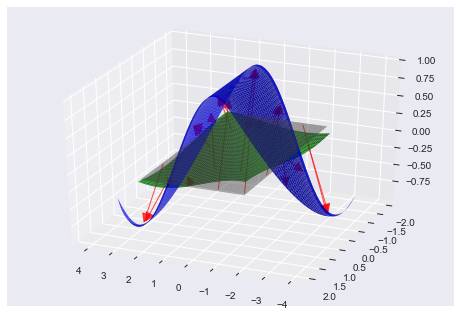

In [30]:
def plot_this(interp=0.1,azim=113,elev=30,plotmode='surface'):
    def f(X,Y):
        return X+Y, np.sin(X), np.cos(X+Y)
    plot_surface_interpolate(f,interp=interp,azim=azim,elev=elev,plotmode=plotmode,urange=2)
#interact(plot_this,interp=(0,1,interp_step),azim=(0,360,degree_step),elev=(0,360,degree_step),plotmode=['points','surface']);
plot_this()

## Example 1 (two representations of the plane)

rectangular and polar. Note what happens when you drag the `interp` slider on the polar representation.

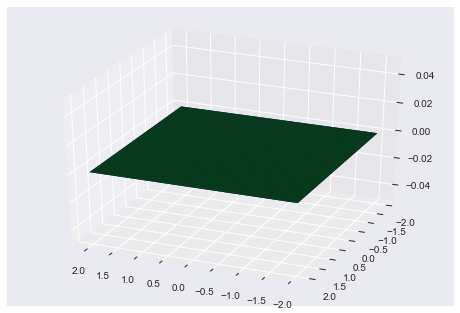

In [31]:
def plot_this(interp=0.1,azim=113,elev=30,plotmode='surface'):
    def f(U1,U2):
        return U1, U2, np.zeros_like(U2)
    plot_surface_interpolate(f,interp=interp,azim=azim,elev=elev,plotmode=plotmode,urange=2)
#interact(plot_this,interp=(0,1,0.01),azim=(0,360,1),elev=(0,360,1),plotmode=['points','surface']);
plot_this()

### This one trips the class up, because you want to say "nothing is going to change" ... but it does ...

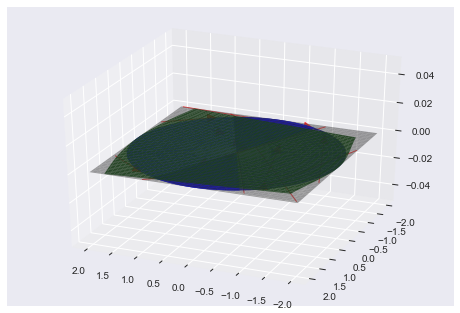

In [32]:
def plot_this(interp=0.1,azim=113,elev=30,plotmode='surface'):
    def f(U1,U2):
        return U1*np.cos(U2), U1*np.sin(U2), np.zeros_like(U2)
    plot_surface_interpolate(f,interp=interp,azim=azim,elev=elev,plotmode=plotmode,urange=2)
#interact(plot_this,interp=(0,1,0.01),azim=(0,360,1),elev=(0,360,1),plotmode=['points','surface']);
plot_this()

## Example 3 (sphere of radius r) (transparency is kind of problematic here)

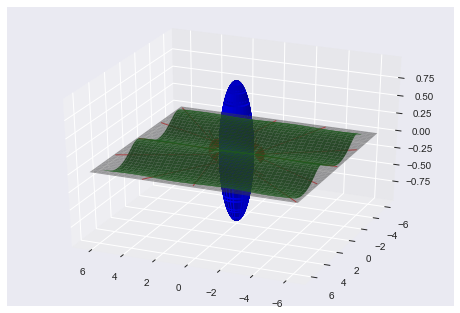

In [34]:
def plot_this(interp=0.1,azim=113,elev=30,plotmode='surface',r=1):
    def f(U1,U2,r=r):
        return r*np.cos(U2)*np.cos(U1), r*np.cos(U2)*np.sin(U1), r*np.sin(U2)
    plot_surface_interpolate(f,interp=interp,azim=azim,elev=elev,plotmode=plotmode,urange=2*np.pi)
#interact(plot_this,interp=(0,1,0.01),azim=(0,360,1),elev=(0,360,1),plotmode=['points','surface'],
#        r=(0,10,0.2));
plot_this()   

## Example 3

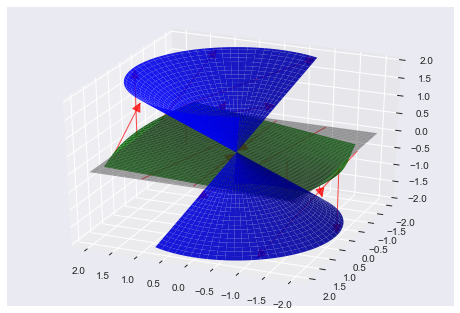

In [35]:
def plot_this(interp=0.1,azim=113,elev=30,plotmode='surface',a=1):
    def f(U1,U2,a=a):
        return U1*np.cos(U2), U1*np.sin(U2), a*U1
    plot_surface_interpolate(f,interp=interp,azim=azim,elev=elev,plotmode=plotmode,urange=2)
#interact(plot_this,interp=(0,1,0.01),azim=(0,360,1),elev=(0,360,1),plotmode=['points','surface'],
#        a=(0,10,0.2));
plot_this()

## Problem 25.1

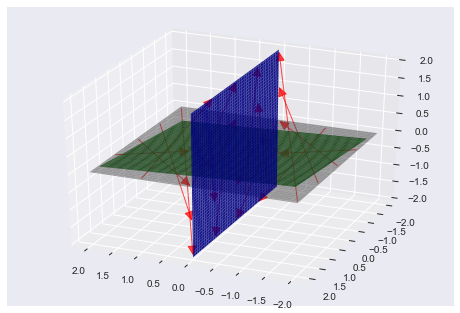

In [36]:
def plot_this(interp=0.1,azim=113,elev=30,plotmode='surface'):
    def f(U1,U2):
        return 0, U1, U2
    plot_surface_interpolate(f,interp=interp,azim=azim,elev=elev,plotmode=plotmode,urange=2)
#interact(plot_this,interp=(0,1,0.01),azim=(0,360,1),elev=(0,360,1),plotmode=['points','surface']);
plot_this()

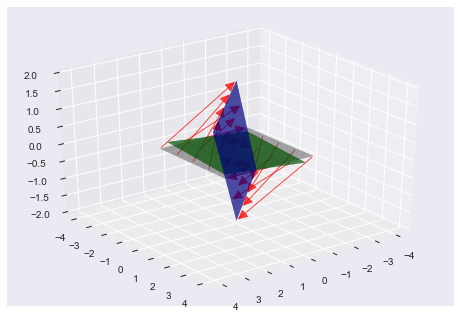

In [37]:
def plot_this(interp=0.1,azim=53,elev=30,plotmode='surface'):
    def f(U1,U2):
        return U1+U2, U1+U2, U1
    plot_surface_interpolate(f,interp=interp,azim=azim,elev=elev,plotmode=plotmode,urange=2)
#interact(plot_this,interp=(0,1,0.01),azim=(0,360,1),elev=(0,360,1),plotmode=['points','surface']);
plot_this()

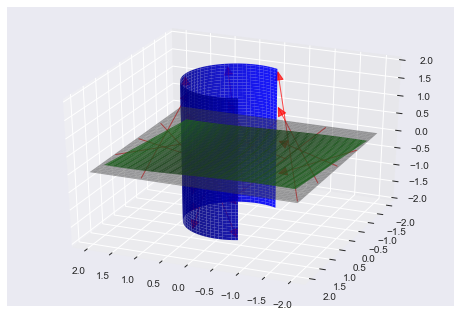

In [38]:
def plot_this(interp=0.1,azim=113,elev=30,plotmode='surface'):
    def f(U1,U2):
        return np.cos(U1), np.sin(U1), U2
    plot_surface_interpolate(f,interp=interp,azim=azim,elev=elev,plotmode=plotmode,urange=2)
#interact(plot_this,interp=(0,1,0.01),azim=(0,360,1),elev=(0,360,1),plotmode=['points','surface']);
plot_this()

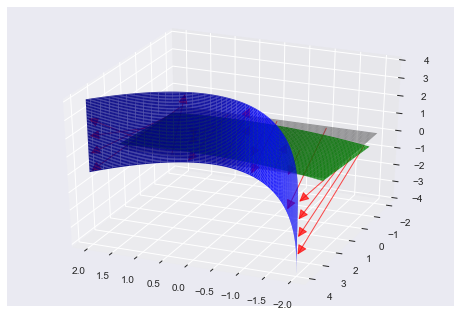

In [39]:
def plot_this(interp=0.1,azim=113,elev=30,plotmode='surface'):
    def s(U1,U2):
        return U1+U2
    def h1(s):
        return s
    def h2(s):
        return s**2
    def h3(s):
        return s
    
    def f(U1,U2):
        S = s(U1,U2)
        return h1(S), h2(S), h3(S)
    def f(U1,U2):
        return h1(U1), h2(U1), h3(U1) + U2
    plot_surface_interpolate(f,interp=interp,azim=azim,elev=elev,plotmode=plotmode,urange=2)
#interact(plot_this,interp=(0,1,0.01),azim=(0,360,1),elev=(0,360,1),plotmode=['points','surface']);
plot_this()

## Monge gauge

Now we should do a specific example in the Monge gauge

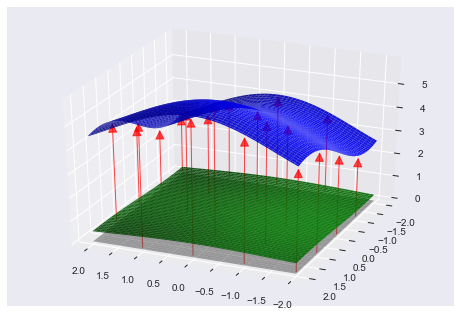

In [40]:
def plot_this(interp=0.1,azim=113,elev=30,plotmode='surface'):
    def f(U1,U2):
        X = U1
        Y = U2
        def h(x,y):
            return 4+ np.cos(x) + np.sin(y)
        return X,Y,h(X,Y)
    plot_surface_interpolate(f,interp=interp,azim=azim,elev=elev,plotmode=plotmode,urange=2)
#interact(plot_this,interp=(0,1,0.01),azim=(0,360,1),elev=(0,360,1),plotmode=['points','surface']);
plot_this()

... and that's it. The whole thing was a ton of fun, and I'm surprised I haven't seen this sort of interpolation easily available before. Let me know if I've missed something!